# 실습예제 : 타이타닉 생존자 예측

- 캐글에서 제공하는 타이타닉 탑승자 데이터 
- April 15, 1912
    
- https://www.kaggle.com/c/titanic/data

In [38]:
# from mymodule.titanicProcess import preprocess
from mymodule.evals import print_eval_score, show_confusion_matrix
from mymodule.titanicPreprocess import preprocess

In [39]:
# import importlib
# import mymodule
# importlib.reload(mymodule)

In [40]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score, classification_report
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split ,GridSearchCV,cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## 1. 데이터 파악

In [41]:
def prepareData(data,encode='label'):
    df = preprocess(data, encode=encode)
    X=df.drop('Survived', axis=1)
    y=df.Survived
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    return X_train, X_test, y_train, y_test

In [42]:
titan = pd.read_csv('titanic/train.csv')
X_train, X_test, y_train, y_test = prepareData(titan, encode='label')


In [43]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [44]:
def show_dtree(model, fname,imgName, feature_names, target_names):
    clf.fit(X_train,y_train)
    export_graphviz(model, out_file=fname, feature_names=feature_names,class_names=target_names, filled=True)
    with open(fname) as f:
        dot_graph = f.read()
    return graphviz.Source(dot_graph)

from subprocess import run
from IPython.display import Image
def show_dtree_image(model, fname, imgname, feature_names, target_names):
    export_graphviz(model, out_file=fname, feature_names=feature_names,
                    class_names=target_names, filled=True)
    run(['dot','-Tpng',fname,'-o', imgname, '-Gdpi=600'])
    Image(filename=imgname)

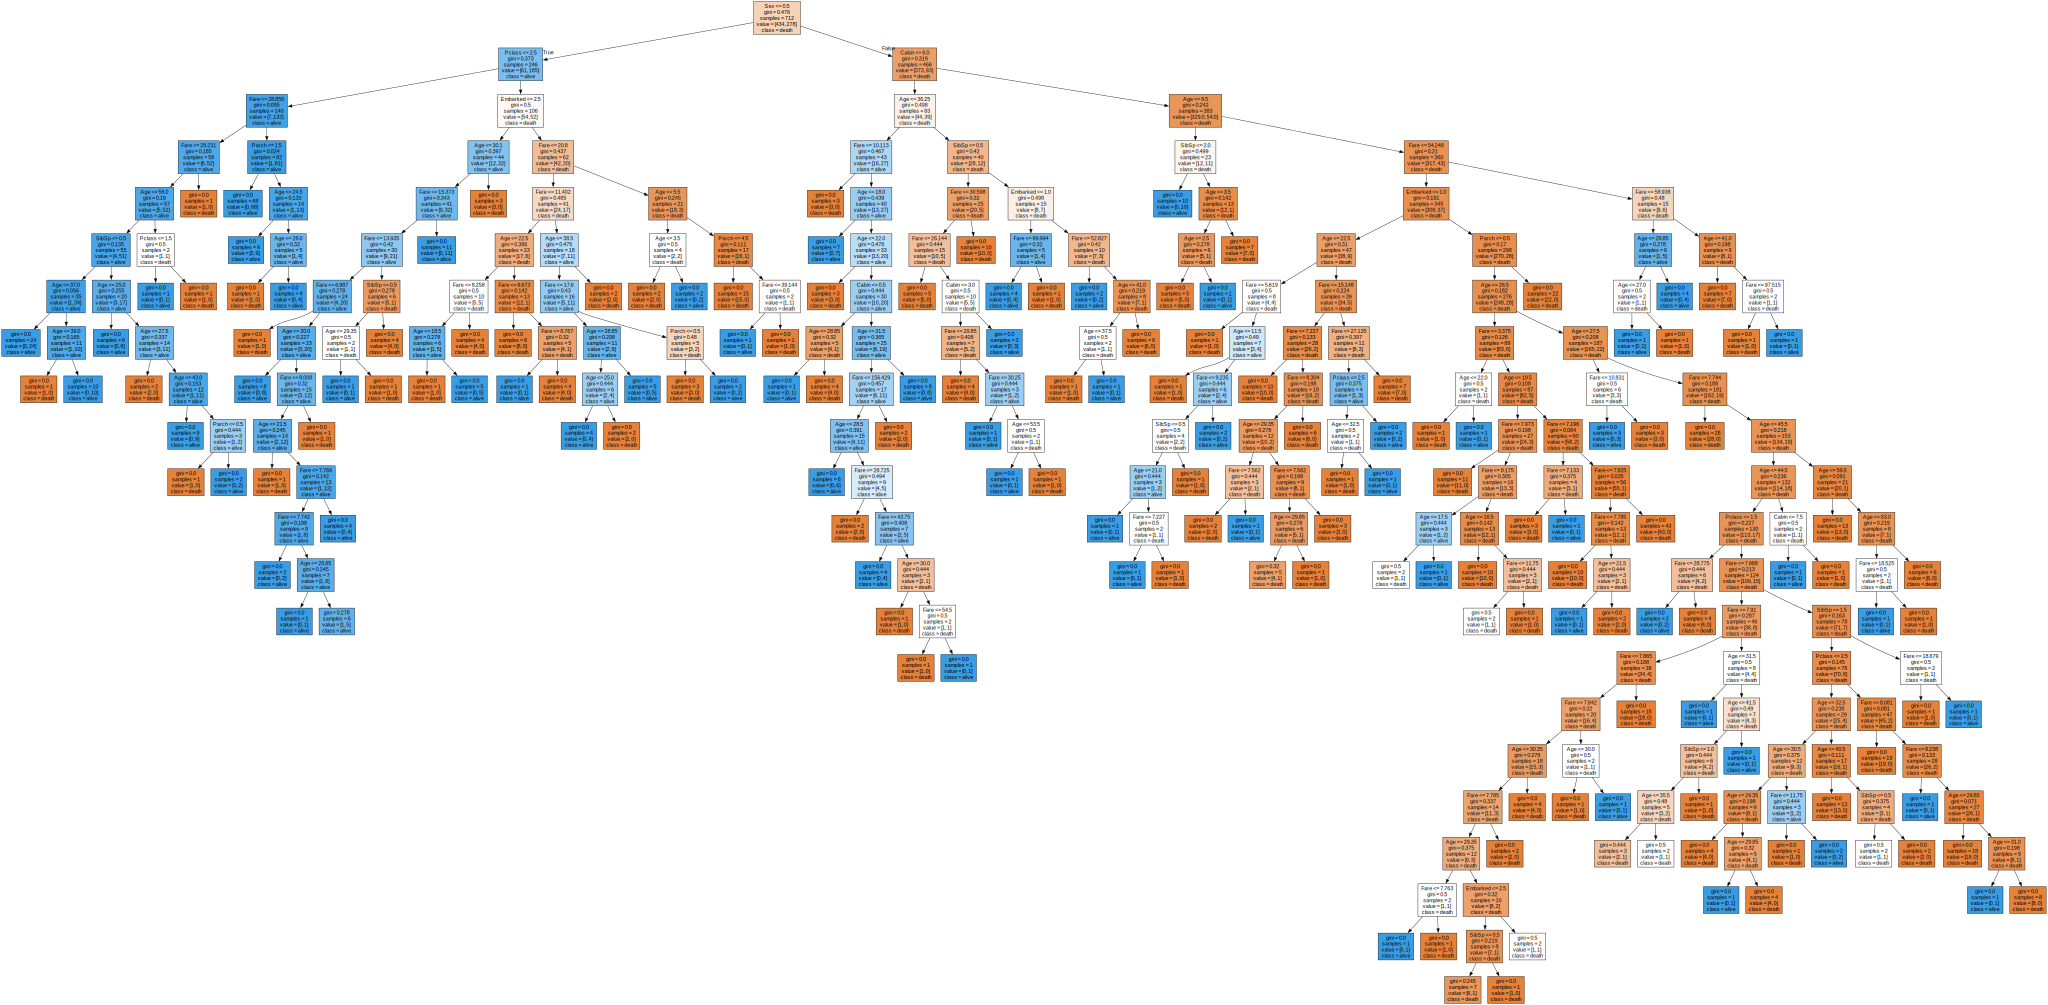

In [45]:
import graphviz
fname = 'output/titanic_tree1.dot'
imgName = 'output/titanic_tree1.png'
ftr_names = list(X_train.columns)
target_names = ['death','alive']
show_dtree(clf, fname,imgName, ftr_names, target_names)

In [46]:
print(f'트리의 높이: {clf.get_depth()}, 트리의 리프노드수: {clf.get_n_leaves()}')

트리의 높이: 21, 트리의 리프노드수: 155


* Passengerid: 탑승자 데이터 일련번호
* survived: 생존 여부, 0 = 사망, 1 = 생존
* Pclass: 티켓의 선실 등급, 1 = 일등석, 2 = 이등석, 3 = 삼등석
* sex: 탑승자 성별
* name: 탑승자 이름
* Age: 탑승자 나이
* sibsp: 같이 탑승한 형제자매 또는 배우자 인원수
* parch: 같이 탑승한 부모님 또는 어린이 인원수
* ticket: 티켓 번호
* fare: 요금
* cabin: 선실 번호
* embarked: 중간 정착 항구 C = Cherbourg, Q = Queenstown, S = Southampton

In [47]:
def plot_ftr_importances(model, feature_names):
    imp = clf.feature_importances_
    idx = list(reversed(np.argsort(imp)))
    plt.figure(figsize=(6,4))
    sns.barplot(x=imp[idx], y=[feature_names[i] for i in idx])
    plt.title('Feature Importance with titanic data')
    plt.show()

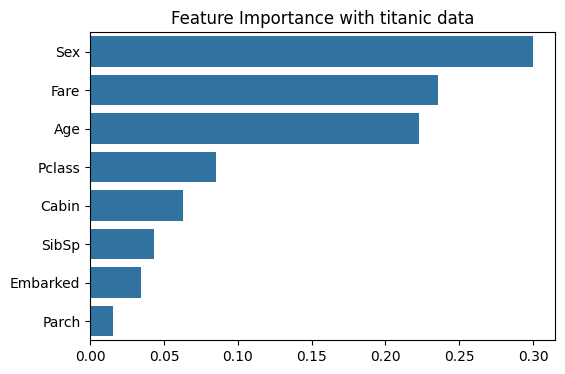

In [48]:
plot_ftr_importances(clf, ftr_names)

In [49]:
## from sklearn.model_selection import cross_val_score
depth_range = range(2, 21)
score_list=[]
for depth in depth_range:
    dt_clf = DecisionTreeClassifier(max_depth=depth,random_state=2020158011)
    scores = cross_val_score(dt_clf, X_train, y_train,scoring='roc_auc', cv=5)
    score_list.append(np.round(np.mean(scores),5))

result_df = pd.DataFrame({'maxDepth' : depth_range, 'ROC_AUC' : score_list})

In [50]:
result_df

,maxDepth,ROC_AUC
0,2,0.82123
1,3,0.85157
2,4,0.84662
3,5,0.84191
4,6,0.84017
5,7,0.81386
6,8,0.79521
7,9,0.79119
8,10,0.76517
9,11,0.76788


In [51]:
best_score = result_df['ROC_AUC'].max()
best_score_idx = result_df['ROC_AUC'].argmax()

In [52]:
best_depth = result_df.iloc[best_score_idx]['maxDepth']
print(f' 최적의 성능: {best_score} -> Max depth : {best_depth}')

 최적의 성능: 0.85157 -> Max depth : 3.0


In [53]:
dt_clf = DecisionTreeClassifier(random_state=2020158011)
params = {'min_samples_split' : [2, 4, 8, 16, 24],
          'max_depth' : [2, 3, 4, 6, 8, 10],
          'min_samples_leaf' : [1, 3, 5, 7, 9, 15]}
grid = GridSearchCV(dt_clf, param_grid=params, cv=5, scoring='roc_auc')
grid.fit(X_train, y_train)

,estimator,DecisionTreeC...te=2020158011)
,param_grid,"{'max_depth': [2, 3, ...], 'min_samples_leaf': [1, 3, ...], 'min_samples_split': [2, 4, ...]}"
,scoring,'roc_auc'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,criterion,'gini'


In [54]:
result_df = pd.DataFrame(grid.cv_results_)[['params','mean_test_score','rank_test_score']]
result_df.sort_values(['rank_test_score'])

,params,mean_test_score,rank_test_score
149,"{'max_depth': 8, 'min_samples_leaf': 15, 'min_...",0.860084,1
146,"{'max_depth': 8, 'min_samples_leaf': 15, 'min_...",0.860084,1
147,"{'max_depth': 8, 'min_samples_leaf': 15, 'min_...",0.860084,1
145,"{'max_depth': 8, 'min_samples_leaf': 15, 'min_...",0.860084,1
148,"{'max_depth': 8, 'min_samples_leaf': 15, 'min_...",0.860084,1
...,...,...,...
122,"{'max_depth': 8, 'min_samples_leaf': 1, 'min_s...",0.808976,176
121,"{'max_depth': 8, 'min_samples_leaf': 1, 'min_s...",0.807792,177
120,"{'max_depth': 8, 'min_samples_leaf': 1, 'min_s...",0.795208,178
151,"{'max_depth': 10, 'min_samples_leaf': 1, 'min_...",0.792699,179


In [55]:
print(result_df[result_df['rank_test_score']==1]['params'])

145    {'max_depth': 8, 'min_samples_leaf': 15, 'min_...
146    {'max_depth': 8, 'min_samples_leaf': 15, 'min_...
147    {'max_depth': 8, 'min_samples_leaf': 15, 'min_...
148    {'max_depth': 8, 'min_samples_leaf': 15, 'min_...
149    {'max_depth': 8, 'min_samples_leaf': 15, 'min_...
Name: params, dtype: object


In [56]:
best_clf = grid.best_estimator_
pred = best_clf.predict(X_test)
pred_proba = best_clf.predict_proba(X_test)[:,1]
print(f'best RPC_AUC : {roc_auc_score(y_test, pred_proba) :.4f}')

best RPC_AUC : 0.8411


In [57]:
grid.best_params_

{'max_depth': 8, 'min_samples_leaf': 15, 'min_samples_split': 2}

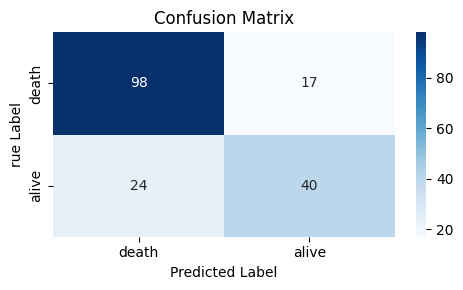

In [58]:
show_confusion_matrix(y_test, pred, target_names)

In [59]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.80      0.85      0.83       115
           1       0.70      0.62      0.66        64

    accuracy                           0.77       179
   macro avg       0.75      0.74      0.74       179
weighted avg       0.77      0.77      0.77       179



In [62]:
print_eval_score(y_test, pred, pred_proba, )

confusion matrix:
[[98 17]
 [24 40]]
accuracy : 0.7709, recall : 0.6250, precision : 0.7018
f1: 0.6612, g-measure: 0.6623


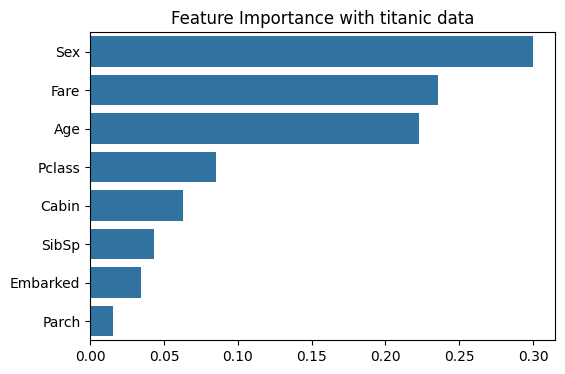

In [66]:
plot_ftr_importances(best_clf, ftr_names)

### 2) 문자열 변수(피처) 빈도 분포 확인

- value_counts()

### 3) 문자열 변수 Cabin값 변경

### 4) 성별에 따른 생존자수 분포(EDA)

### 5) 수치형 변수의 구간화(binning)

#### 연령대에 따른 생존자수 분포
- 연령은 수치형 변수이므로 범주형으로 구간화(binning)

### 6) 인코딩(encoding)

- Sex, Cabin, Embarked 변수에 대하여 레이블 인코딩

### 7) 삭제

- PassengerId, Name, Ticket 변수 삭제
- drop(labels=None, axis=0, inplace=False) 함수 사용

### 전처리 함수 작성

---

## 3. 생존자 예측 모델링

### 1단계. 데이터 로딩
- 피처 데이터셋, 레이블 데이터셋 추출

### 2단계. 데이터 전처리
- 피처 데이터 세트에 transform_features()를 적용해 데이터 가공

### 3단계. Data Split

### 4단계. 분류 알고리즘을 적용한 학습/예측/평가

- 3개의 분류 알고리즘으로 예측 수행하고 평가
    - 결정 트리 : DecisionTreeClassifier
    - 랜덤 포레스트 : RandomForestClassifier
    - 로지스틱 회귀 : LogisticRegression   
- 예측 성능 평가 지표 : accuracy_score()

### 5단계. 교차 검증을 통한 모델 성능 향상

- 결정 트리 모델에 대하여 교차검증
- KFold 클래스, cross_val_score(), GridSearchCV 클래스 사용

#### 1) KFold를 이용한 교차검증

#### 2) cross_val_score()를 이용해 교차 검증 수행

### 6단계. 하이퍼파라미터 튜닝

- GridSearchCV 클래스를 이용해 하이퍼 파리미터를 튜닝

------------------------------------------------